In [1]:
%load_ext autoreload

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../.env")

True

In [4]:
%autoreload 2

import json
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import yaml
from PIL import Image

from estuary.util import false_color, masked_contrast_stretch

In [23]:
labels = pd.read_csv(Path("/Volumes/x10pro/estuary/dove/labels.csv"))
labels.head()

,region,source_tif,label,acquired,instrument
0,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-09-03 18:37:27,dove
1,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-11-02 18:35:56,dove
2,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-07-10 18:21:59,dove
3,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-06-09 18:05:19,dove
4,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-01-01 18:06:34,dove


In [106]:
def add_clear_percent(pth):
    pth = Path(pth)

    key = "_".join(pth.stem.split("_")[:2])
    udm_pth = next(p for p in pth.parent.glob("*udm2_clip.tif") if key in p.stem)

    with rasterio.open(udm_pth) as src:
        data = src.read([5, 6, 7])
    clear = ~np.logical_or(data[0], data[1])
    conf = data[-1]
    clear[conf < 1] = 0

    pct = 100 * clear.sum() / float(clear.shape[1]) / float(clear.shape[0])
    return pct


labels["clear_percent"] = labels.source_tif.apply(add_clear_percent)

In [107]:
labels["unsure"] = labels.label.apply(lambda a: int(a == "unsure"))
labels.head()

,region,source_tif,label,acquired,instrument,clear_percent,clear_confidence_percent,cloud_percent,visible_confidence_percent,visible_percent,unsure
0,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-09-03 18:37:27,dove,100.0,96,0,82,100,0
1,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-11-02 18:35:56,dove,100.0,90,20,73,80,0
2,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-07-10 18:21:59,dove,100.0,87,17,55,83,0
3,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-06-09 18:05:19,dove,100.0,100,0,100,100,0
4,65,/Volumes/x10pro/estuary/superdove/results/2022...,closed,2022-01-01 18:06:34,dove,100.0,93,0,68,100,0


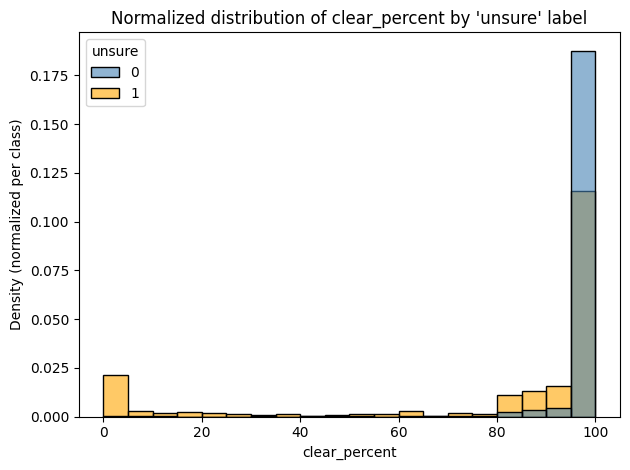

In [108]:
sns.histplot(
    data=labels,
    x="clear_percent",
    hue="unsure",
    bins=20,
    stat="density",  # or "probability"
    common_norm=False,  # don't normalize across classes
    palette={0: "steelblue", 1: "orange"},
    alpha=0.6,
)

plt.xlabel("clear_percent")
plt.ylabel("Density (normalized per class)")
plt.title("Normalized distribution of clear_percent by 'unsure' label")
plt.tight_layout()
plt.show()

In [112]:
labels[(labels.clear_percent < 5) & (labels.unsure == 0)]

,region,source_tif,label,acquired,instrument,clear_percent,clear_confidence_percent,cloud_percent,visible_confidence_percent,visible_percent,unsure
1055,37,/Volumes/x10pro/estuary/dove/results/2018/11/3...,closed,2018-11-01 18:01:19,dove,0.000000,39,44,49,8,0
1243,48,/Volumes/x10pro/estuary/dove/results/2020/6/48...,open,2020-06-02 18:35:31,dove,0.000000,57,20,52,53,0
1425,50,/Volumes/x10pro/estuary/dove/results/2019/4/50...,open,2019-04-01 18:27:32,dove,0.000000,61,79,61,0,0
1426,50,/Volumes/x10pro/estuary/dove/results/2019/3/50...,open,2019-03-01 18:33:59,dove,0.113205,49,6,57,1,0
2909,62,/Volumes/x10pro/estuary/dove/results/2018/5/62...,perched open,2018-05-04 18:31:24,dove,0.000000,60,30,56,10,0
2979,84,/Volumes/x10pro/estuary/dove/results/2019/3/84...,open,2019-03-04 18:38:01,dove,0.000000,49,19,56,7,0
3116,72,/Volumes/x10pro/estuary/dove/results/2018/2/72...,open,2018-02-05 18:47:08,dove,0.841190,55,22,54,2,0
3702,68,/Volumes/x10pro/estuary/dove/results/2020/3/68...,closed,2020-03-01 18:39:10,dove,0.000000,58,5,52,72,0
4377,17,/Volumes/x10pro/estuary/dove/results/2019/12/1...,closed,2019-12-01 18:13:46,dove,0.000000,41,37,47,12,0
4488,41,/Volumes/x10pro/estuary/dove/results/2020/6/41...,open,2020-06-02 18:29:28,dove,0.000000,52,18,53,25,0


region                                                                       96
source_tif                    /Volumes/x10pro/estuary/superdove/results/2023...
label                                                                    unsure
acquired                                                    2023-08-14 18:10:13
instrument                                                                 dove
clear_percent                                                          94.45157
clear_confidence_percent                                                     71
cloud_percent                                                                96
visible_confidence_percent                                                   56
visible_percent                                                               4
unsure                                                                        1
Name: 418, dtype: object
20230814_181013_74_2420_3B_AnalyticMS_SR_8b_clip


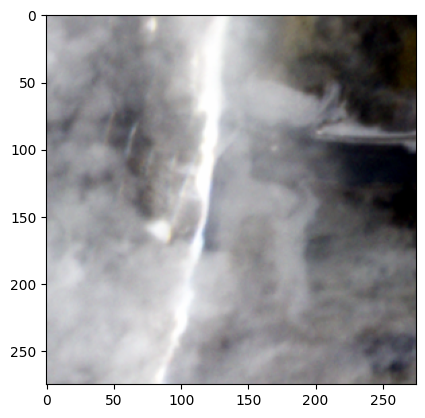

In [131]:
row = labels[(labels.clear_percent > 90) & (labels.unsure == 1)].iloc[9]

print(row)
pth = row.source_tif
print(Path(pth).stem)

with rasterio.open(pth) as src:
    data = src.read(out_dtype=np.float32)
    nodata = src.read(1, masked=True).mask
    img = false_color(data, nodata)

plt.figure()
plt.imshow(img)

In [71]:
with rasterio.open(Path(pth).parent / "20180301_184223_100d_3B_udm2_clip.tif") as src:
    nodata = ~src.read_masks(1)
    data = src.read(out_dtype=np.float32)

In [80]:
np.unique(data[6])

array([ 0., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46.,
       47., 48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59.,
       60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72.,
       73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85.,
       86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96.],
      dtype=float32)

<Axes: >

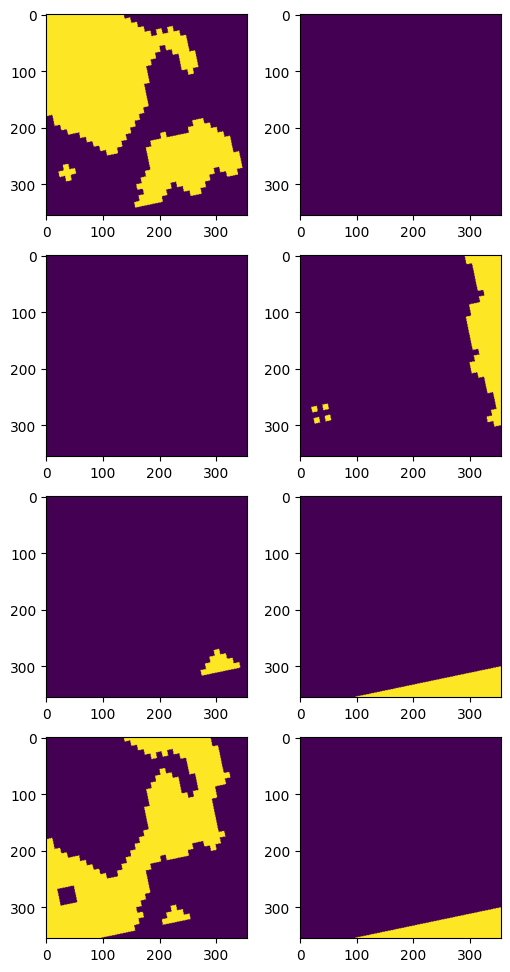

In [79]:
from rasterio.plot import show

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(3 * 2, 3 * 4))

show(data[0], ax=axes[0, 0])
show(data[1], ax=axes[1, 0])
show(data[2], ax=axes[2, 0])
show(data[3], ax=axes[3, 0])
show(data[4], ax=axes[0, 1])
show(data[5], ax=axes[1, 1])
show(data[6] == 0, ax=axes[2, 1])
show(data[7] == 1, ax=axes[3, 1])

In [24]:
runs = []
base = Path("/Users/kyledorman/data/results/estuary/train")
paths = list(base.glob("20251008*")) + [sorted(list(base.glob("20251006*")))[-1]]
for pth in paths:
    if not (pth / "preds.csv").exists():
        continue
    df = pd.read_csv(pth / "preds.csv")

    with open(pth / "cli_diff.yaml") as f:
        conf = yaml.safe_load(f)
    if "20251003" in pth.name:
        df["smooth_factor"] = 0.0
    else:
        df["smooth_factor"] = conf.get("smooth_factor", 0.0)
    df["perch_smooth_factor"] = conf.get("perch_smooth_factor", 0.0)
    df["epochs"] = conf.get("epochs", 0)
    df["model"] = pth.name
    runs.append(df)

runs_df = pd.concat(runs, ignore_index=True)

runs_df.head()

,source_tif,y_true,y_prob,y_pred,region,fold,orig_label,dataset,correct,smooth_factor,perch_smooth_factor,epochs,model
0,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000003,0,65,-1,closed,train,True,0.0,0.4,30,20251008-151833
1,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000005,0,65,-1,closed,train,True,0.0,0.4,30,20251008-151833
2,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000010,0,65,-1,closed,train,True,0.0,0.4,30,20251008-151833
3,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000015,0,65,-1,closed,train,True,0.0,0.4,30,20251008-151833
4,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000017,0,65,-1,closed,train,True,0.0,0.4,30,20251008-151833


In [25]:
grouped_results = (
    runs_df.sort_values(by=["region", "epochs", "perch_smooth_factor", "smooth_factor"])
    .groupby(by=["region", "model", "dataset"], as_index=False)
    .correct.mean()
    .rename(columns={"correct": "accuracy"})
)

grouped_results.head()

,region,model,dataset,accuracy
0,11,20251006-115232,test,1.0
1,11,20251006-115232,train,1.0
2,11,20251006-115232,val,1.0
3,11,20251008-111541,test,1.0
4,11,20251008-111541,train,1.0


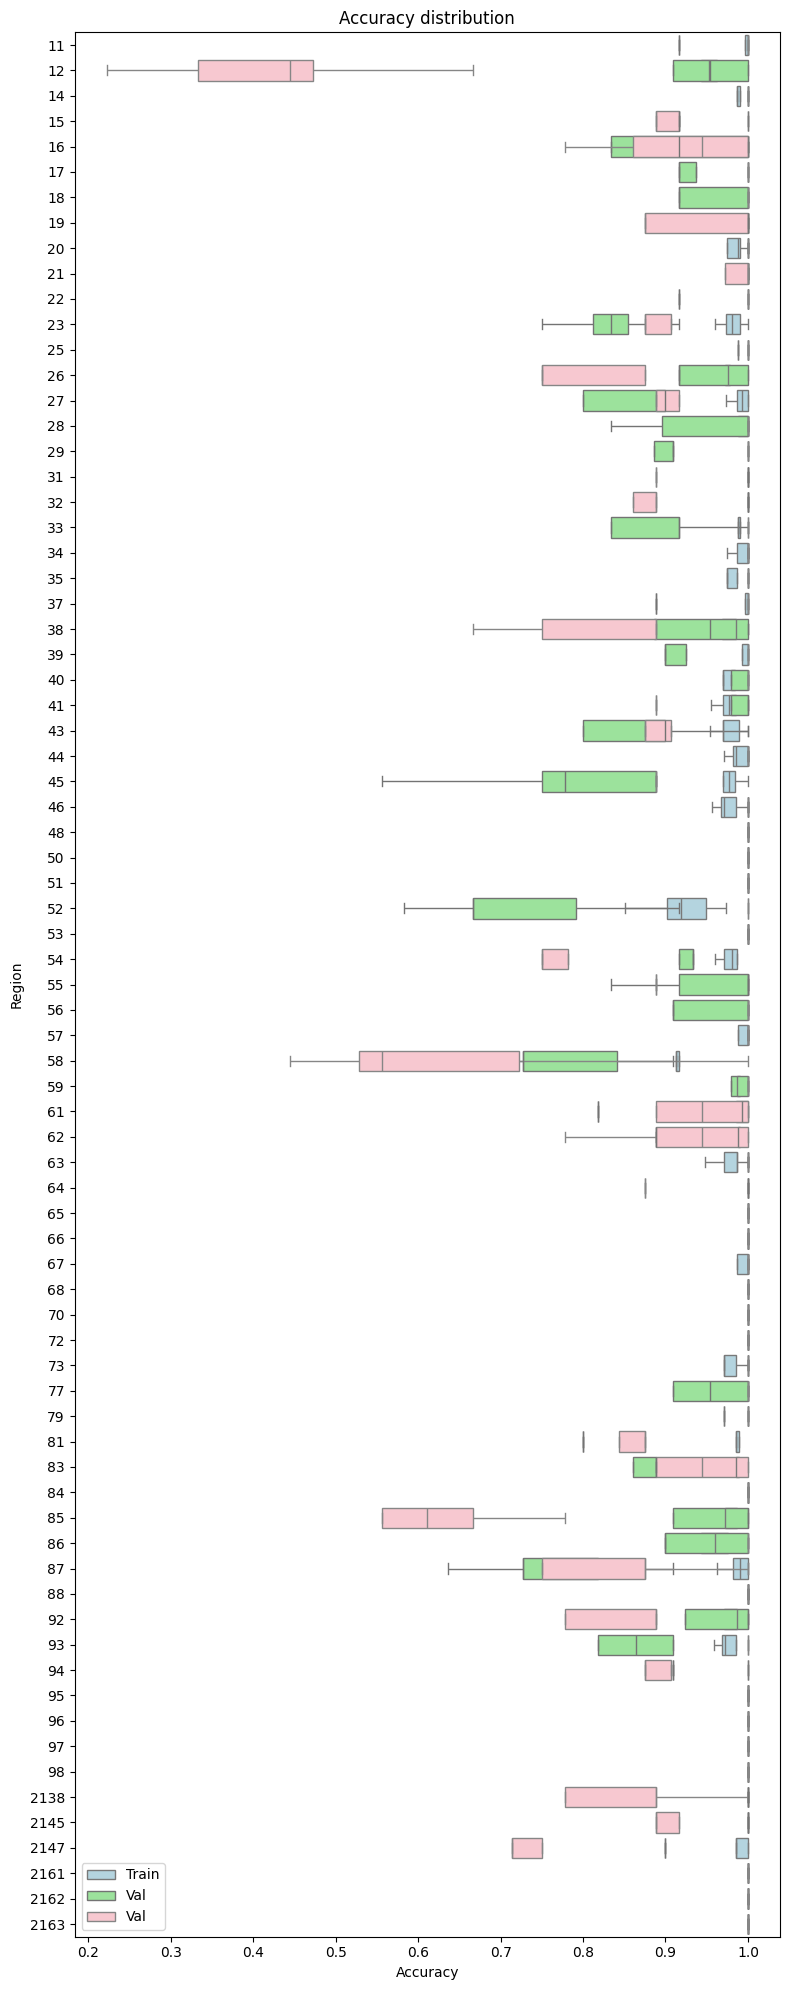

In [26]:
plt.figure(figsize=(8, 20))  # tall plot for 75 regions

df = grouped_results.copy()
df["region"] = df.region.apply(str)

# Boxplots for train per region
sns.boxplot(
    data=df[df["dataset"] == "train"],
    y="region",
    x="accuracy",
    color="lightblue",
    showfliers=False,
    orient="h",
    label="Train",
    # color="lightblue", marker="D", s=30, label="Train"
)

# Overlay val points
sns.boxplot(
    data=df[df["dataset"] == "val"],
    y="region",
    x="accuracy",
    color="lightgreen",
    showfliers=False,
    orient="h",
    label="Val",
    # color="lightblue", marker="D", s=30, label="Train"
)

# Overlay test points
sns.boxplot(
    data=df[df["dataset"] == "test"],
    y="region",
    x="accuracy",
    color="pink",
    showfliers=False,
    orient="h",
    label="Val",
)

plt.title("Accuracy distribution")
plt.xlabel("Accuracy")
plt.ylabel("Region")
plt.legend()
plt.tight_layout()

plt.show()

In [36]:
a = runs_df.groupby("region").correct.mean()
worst_regions = a.sort_values().iloc[:10].index.tolist()
worst_regions

[58, 12, 52, 87, 85, 45, 54, 81, 38, 23]

<Axes: xlabel='accuracy', ylabel='model'>

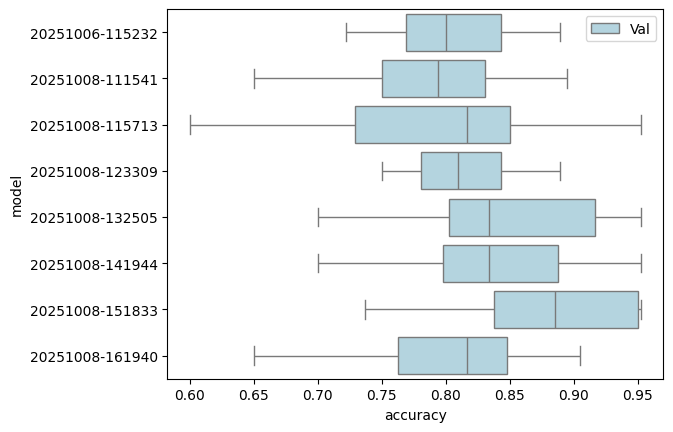

In [43]:
df = (
    runs_df[runs_df.dataset != "train"]
    .groupby(["model", "region"], as_index=False)
    .correct.mean()
    .rename(columns={"correct": "accuracy"})
)
a = df.groupby("region").accuracy.min()
worst_regions = a.sort_values().iloc[:10].index.tolist()

adf = df[df.region.isin(worst_regions)].copy().sort_values("model")
adf["region"] = adf.region.apply(str)

sns.boxplot(
    data=adf,
    y="model",
    x="accuracy",
    color="lightblue",
    showfliers=False,
    orient="h",
    label="Val",
    # color="lightblue", marker="D", s=30, label="Train"
)

# sns.boxplot(
#     data=df[df["dataset"]=="test"],
#     y="model", x="accuracy",
#     color="pink", showfliers=False, orient="h", label="Test"
#     # color="lightblue", marker="D", s=30, label="Train"
# )

# sns.boxplot(
#     data=df[df["dataset"]=="train"],
#     y="model", x="accuracy",
#     color="green", showfliers=False, orient="h", label="Train"
#     # color="lightblue", marker="D", s=30, label="Train"
# )

In [48]:
skipped_regions = pd.read_csv("/Volumes/x10pro/estuary/geos/skipped_regions.csv")[
    "Site code"
].to_list()

gdf = gpd.read_file("/Users/kyledorman/data/estuary/geos/ca_data_w_usgs.geojson")
gdf = gdf[~gdf["Site code"].isin(skipped_regions)].copy()
gdf = gdf.set_index("Site code")
gdf.head()

,Latitude,Longitude,Region,Nation,Site name,Studied (1) / Not Studied (0),station_nm,site_no,site_latitude,site_longitude,geometry
Site code,,,,,,,,,,,
11,32.933,-117.260,North America,USA,Los Penasquitos Lagoon,1,None,None,None,None,POINT (-117.26 32.933)
12,33.166,-117.358,North America,USA,Buena Vista Lagoon,0,None,None,None,None,POINT (-117.358 33.166)
14,33.203,-117.391,North America,USA,San Luis Rey River,0,None,None,None,None,POINT (-117.391 33.203)
15,33.231,-117.416,North America,USA,Santa Margarita River,1,SANTA MARGARITA RIVER ESTUARY NR OCEANSIDE CA,11046050,33.2294795,-117.4103174,POINT (-117.416 33.231)
16,33.291,-117.465,North America,USA,Las Fores Creek,0,LAS FLORES C LAGOON A MOUTH NR OCEANSIDE CA,11046102,33.29055556,-117.465,POINT (-117.465 33.291)


In [89]:
plt.figure()
pth = list(
    Path("/Volumes/x10pro/estuary/skysat/results/").glob("*/43/files/*pansharpened_clip.tif")
)[0]
with rasterio.open(pth) as src:
    data = src.read()
    nodata = src.read(1, masked=True).mask
    img = false_color(data, nodata)
    img = Image.fromarray(img).resize((224, 224))
    # .save("/Users/kyledorman/data/estuary/display/region_53.png")
plt.imshow(img)

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

In [90]:
with open("/Volumes/x10pro/estuary/dataset/normalization/stats.json") as f:
    stats = json.load(f)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler

pt = PowerTransformer(standardize=False)
pt.lambdas_ = np.array(stats["lambdas"])
st = StandardScaler()
st.scale_ = np.array(stats["stds"])
st.mean_ = np.array(stats["means"])

norm = Pipeline([("PowerTransformer", pt), ("StandardScaler", st)])

In [91]:
pth = list(
    Path("/Volumes/x10pro/estuary/skysat/results/").glob("*/43/files/*pansharpened_clip.tif")
)[0]
print(pth)
with open("/Volumes/x10pro/estuary/dataset/normalization/stats.json") as f:
    stats = json.load(f)

plt.figure(figsize=(10, 10))

EIGHT_TO_4 = (7, 5, 3, 1)
with rasterio.open(pth) as src:
    data = src.read(out_dtype=np.float32)
    nodata = src.read(1, masked=True).mask
    rgb = masked_contrast_stretch(data[[2, 1, 0]], ~nodata)
    plt.imshow(rgb.transpose((1, 2, 0)))

    img = np.zeros((8, *data.shape[1:]), dtype=data.dtype)
    for i, b in enumerate(reversed(EIGHT_TO_4)):
        img[b] = data[i]
    shp = img.shape
    img = norm.transform(img.reshape(len(img), -1).T).T.reshape(shp)
    img = np.array([img[i] for i in reversed(EIGHT_TO_4)])

bgrnir = ["B", "G", "R", "NIR"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(img[i])
    ax.set_title(bgrnir[i])
fig.tight_layout()
plt.show()

IndexError: list index out of range

/Volumes/x10pro/estuary/dove/results/2022/1/43/files/20220101_180639_73_1067_3B_AnalyticMS_SR_clip.tif


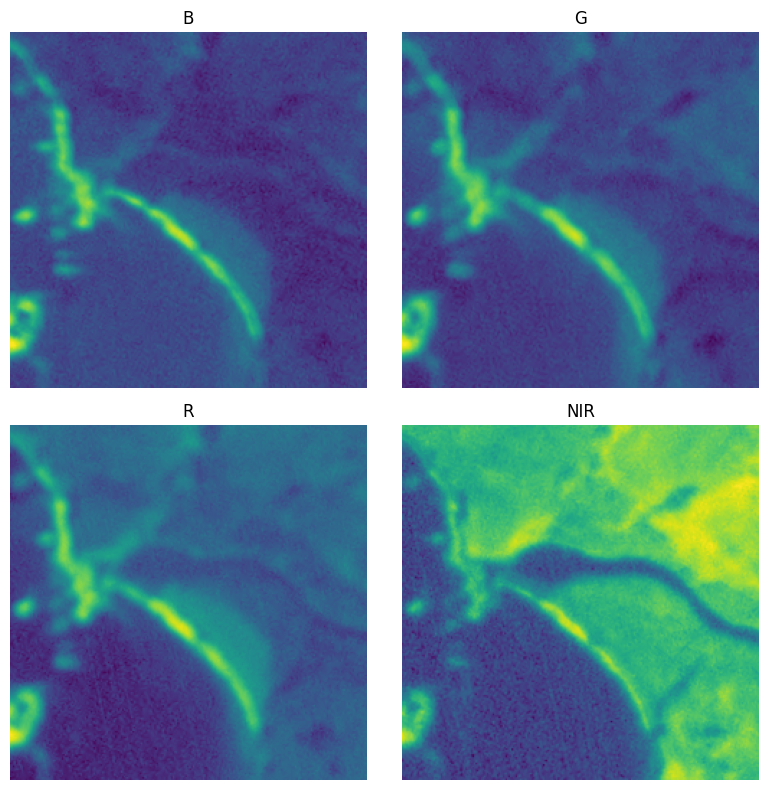

In [94]:
pth = list(Path("/Volumes/x10pro/estuary/dove/results/").glob("*/*/43/files/*SR*clip.tif"))[0]
with open("/Volumes/x10pro/estuary/dataset/normalization/stats.json") as f:
    stats = json.load(f)

print(pth)

# plt.figure()

EIGHT_TO_4 = (7, 5, 3, 1)
with rasterio.open(pth) as src:
    data = src.read(out_dtype=np.float32)
    nodata = src.read(1, masked=True).mask
    rgb = masked_contrast_stretch(data[[2, 1, 0]], ~nodata)
    # plt.imshow(rgb.transpose((1, 2, 0)))

    img = np.zeros((8, *data.shape[1:]), dtype=data.dtype)
    for i, b in enumerate(reversed(EIGHT_TO_4)):
        img[b] = data[i]
    shp = img.shape
    img = norm.transform(img.reshape(len(img), -1).T).T.reshape(shp)
    img = np.array([img[i] for i in reversed(EIGHT_TO_4)])

bgrnir = ["B", "G", "R", "NIR"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(img[i])
    ax.set_title(bgrnir[i])
fig.tight_layout()
plt.show()

/Volumes/x10pro/estuary/superdove/results/2022/11/43/files/20221102_182420_94_2486_3B_AnalyticMS_SR_8b_clip.tif


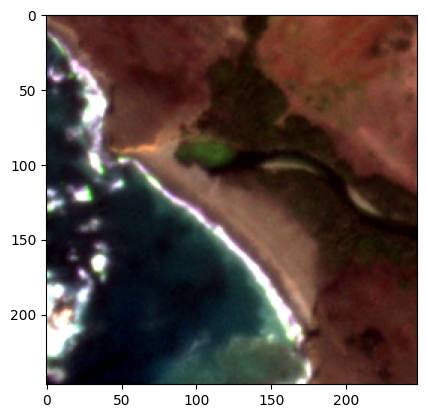

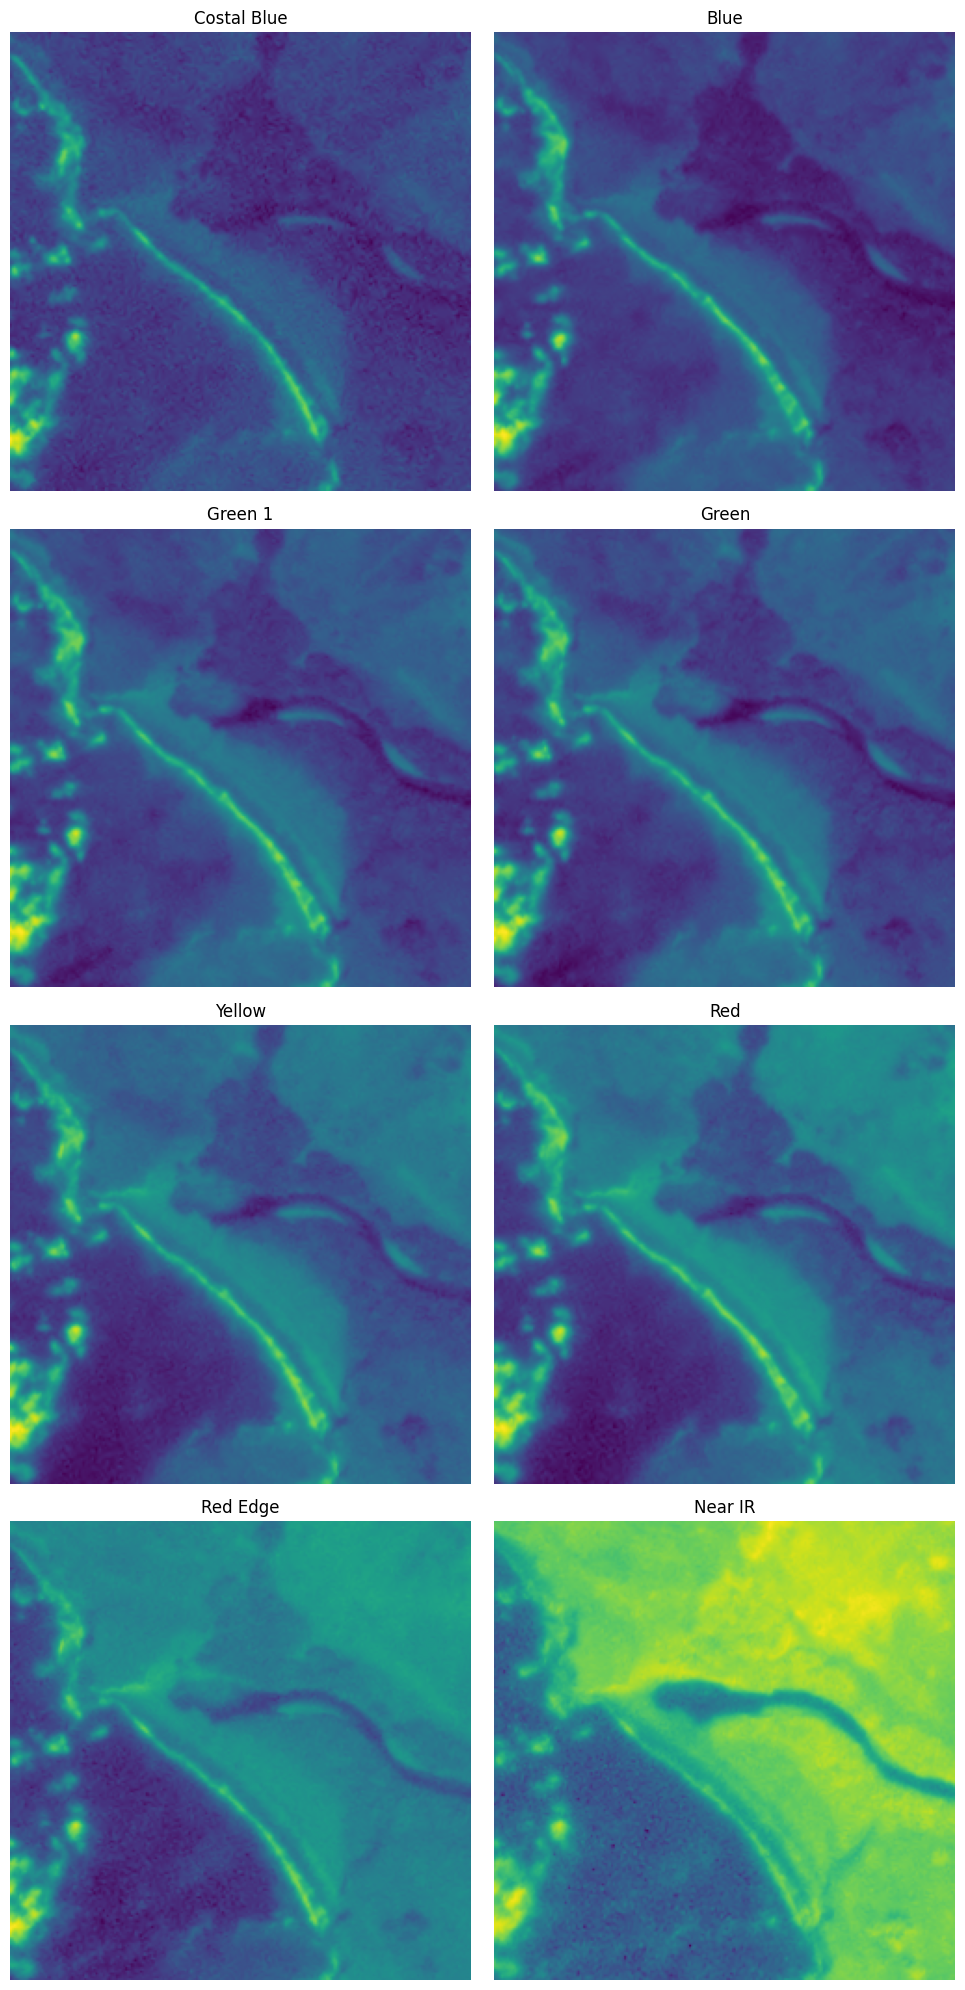

In [97]:
pth = list(Path("/Volumes/x10pro/estuary/superdove/results/").glob("*/*/43/files/*SR*clip.tif"))[1]
with open("/Volumes/x10pro/estuary/dataset/normalization/stats.json") as f:
    stats = json.load(f)

print(pth)

plt.figure()

with rasterio.open(pth) as src:
    img = src.read(out_dtype=np.float32)
    nodata = src.read(1, masked=True).mask
    rgb = masked_contrast_stretch(img[[5, 3, 1]], ~nodata)
    plt.imshow(rgb.transpose((1, 2, 0)))

    shp = img.shape
    img = norm.transform(img.reshape(len(img), -1).T).T.reshape(shp)

from estuary.constants import BAND_NAMES

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(img[i])
    ax.set_title(BAND_NAMES[i])
fig.tight_layout()
plt.show()

In [98]:
contig_preds = pd.read_csv("/Volumes/x10pro/estuary/ca_all/preds.csv")
contig_preds["acquired"] = contig_preds.source_tif.apply(lambda a: parse_dt_from_pth(Path(a)))
contig_preds = contig_preds.sort_values(by=["region", "acquired"])
contig_preds["year"] = contig_preds.acquired.dt.year
contig_preds.head()

,source_tif,y_true,y_prob,y_pred,region,dataset,orig_label,correct,acquired,year
3681,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.998599,1,21,train,open,True,2017-01-14 17:55:15,2017
3682,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.997285,1,21,train,open,True,2017-01-15 17:55:12,2017
3683,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.997597,1,21,train,open,True,2017-01-19 17:54:44,2017
3684,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999996,1,21,train,open,True,2017-02-25 17:55:26,2017
3685,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999997,1,21,train,open,True,2017-03-01 17:56:24,2017


In [105]:
acc_yr = (
    contig_preds.groupby(["year", "region"], as_index=False)
    .correct.mean()
    .rename(columns={"correct": "accuracy"})
)

acc_yr.head()

,year,region,accuracy
0,2017,21,0.989247
1,2017,28,0.978495
2,2017,43,0.903846
3,2017,48,1.000000
4,2017,51,1.000000


In [111]:
acc_yr.region.max()

2145

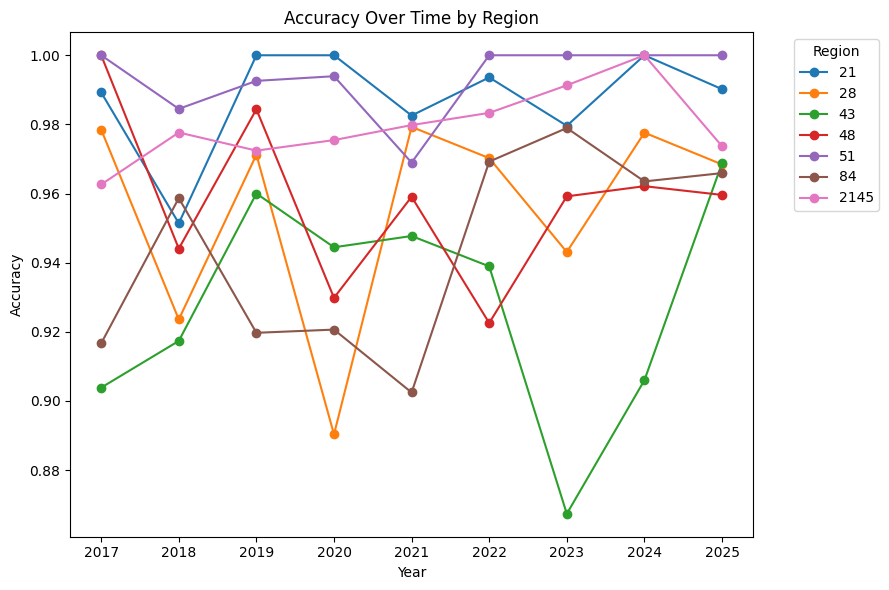

In [113]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 6))

for region, group in acc_yr.groupby("region"):
    group = group.sort_values("year")
    ax.plot(group["year"], group["accuracy"], marker="o", label=region)

ax.set_title("Accuracy Over Time by Region")
ax.set_xlabel("Year")
ax.set_ylabel("Accuracy")
ax.legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

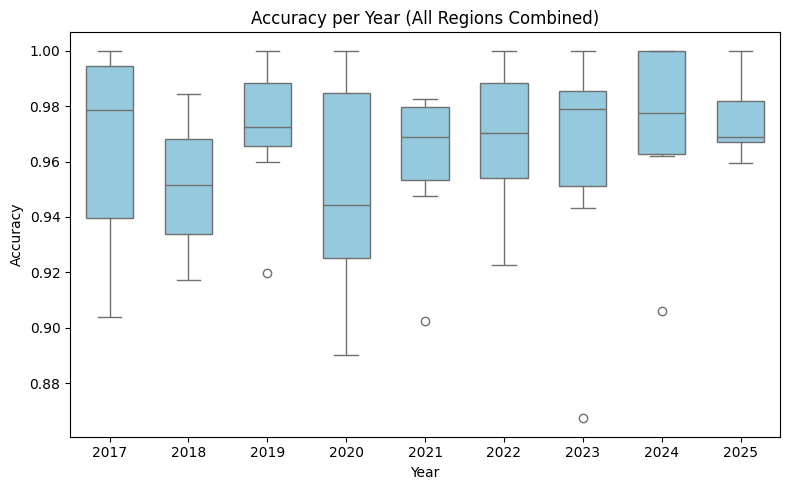

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=acc_yr, x="year", y="accuracy", color="skyblue", width=0.6)
plt.title("Accuracy per Year (All Regions Combined)")
plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()